In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2026-01-17 12:39:13.624379: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-17 12:39:13.686452: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-17 12:39:15.310810: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
file_path = "../data/processed/part-00000-cd530e15-795d-43aa-9731-3388b87f5dc7-c000.csv"
df = pd.read_csv(file_path, parse_dates=["date"])
df = df.sort_values(["ticker", "date"]).reset_index(drop=True)
print(df.head())

  ticker       date     open     high      low    close     volume  \
0   AAPL 2020-09-29  111.697  112.436  110.739  111.243  102615780   
1   AAPL 2020-09-30  110.958  114.345  110.788  112.918  146318692   
2   AAPL 2020-10-01  114.704  114.782  112.937  113.885  119085817   
3   AAPL 2020-10-02  110.089  112.486  109.429  110.219  148407508   
4   AAPL 2020-10-05  111.078  113.746  110.720  113.597  108956998   

   post_count  avg_score  total_score  avg_comments  max_score  
0           0        0.0            0           0.0          0  
1           0        0.0            0           0.0          0  
2           0        0.0            0           0.0          0  
3           0        0.0            0           0.0          0  
4           0        0.0            0           0.0          0  


In [3]:
TICKER = "GME"
df_ticker = df[df['ticker'] == TICKER].copy().reset_index(drop=True)

In [4]:
# Lagged features
df_ticker['prev_close'] = df_ticker['close'].shift(1)
df_ticker['prev_return'] = (df_ticker['close'] - df_ticker['prev_close']) / df_ticker['prev_close']

# Rolling averages
df_ticker['rolling_avg_close'] = df_ticker['close'].rolling(window=3, min_periods=1).mean()
df_ticker['rolling_avg_post'] = df_ticker['post_count'].rolling(window=3, min_periods=1).mean()
df_ticker['rolling_avg_score'] = df_ticker['avg_score'].rolling(window=3, min_periods=1).mean()

# Target: next-day direction
df_ticker['close_next'] = df_ticker['close'].shift(-1)
df_ticker['direction'] = (df_ticker['close_next'] > df_ticker['close']).astype(int)

# Drop first row (NaN) and last row (no next day)
df_ticker = df_ticker.iloc[1:-1].reset_index(drop=True)

In [5]:
df_ticker.head()

,ticker,date,open,high,low,close,volume,post_count,avg_score,total_score,avg_comments,max_score,prev_close,prev_return,rolling_avg_close,rolling_avg_post,rolling_avg_score,close_next,direction
0,GME,2020-09-30,2.5625,2.68992,2.51500,2.5500,24316132,0,0.0,0,0.0,0,2.5875,-0.014493,2.568750,0.0,0.0,2.4425,0
1,GME,2020-10-01,2.5225,2.56250,2.42250,2.4425,18216220,0,0.0,0,0.0,0,2.5500,-0.042157,2.526667,0.0,0.0,2.3475,0
2,GME,2020-10-02,2.3450,2.44500,2.32500,2.3475,17361936,0,0.0,0,0.0,0,2.4425,-0.038895,2.446667,0.0,0.0,2.3650,1
3,GME,2020-10-05,2.3600,2.39750,2.31255,2.3650,11219876,0,0.0,0,0.0,0,2.3475,0.007455,2.385000,0.0,0.0,2.2825,0
4,GME,2020-10-06,2.3900,2.45875,2.27500,2.2825,18141684,0,0.0,0,0.0,0,2.3650,-0.034884,2.331667,0.0,0.0,2.3400,1


In [6]:
SEQ_LEN = 10  # number of days in input sequence
FEATURES = ['open', 'high', 'low', 'close', 'volume', 
            'post_count', 'avg_score', 'total_score', 'avg_comments', 'max_score',
            'prev_close', 'prev_return', 'rolling_avg_close', 'rolling_avg_post', 'rolling_avg_score']

# Scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_ticker[FEATURES])

# Build sequences
X, y = [], []
for i in range(SEQ_LEN, len(scaled_data)):
    X.append(scaled_data[i-SEQ_LEN:i])
    y.append(df_ticker['direction'].iloc[i])

X, y = np.array(X), np.array(y)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (92, 10, 15) y shape: (92,)


In [7]:
split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 64
Test size: 28


In [8]:
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, len(FEATURES)), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2026-01-17 12:39:32.478335: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/akstrov/miniforge3/envs/py311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,929 (128.63 KB)

 Trainable params: 32,929 (128.63 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.4902 - loss: 0.6933 - val_accuracy: 0.5385 - val_loss: 0.6930
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3922 - loss: 0.6959 - val_accuracy: 0.5385 - val_loss: 0.6934
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3333 - loss: 0.6971 - val_accuracy: 0.5385 - val_loss: 0.6934
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5294 - loss: 0.6935 - val_accuracy: 0.5385 - val_loss: 0.6935
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5294 - loss: 0.6930 - val_accuracy: 0.5385 - val_loss: 0.6936
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3529 - loss: 0.6958 - val_accuracy: 0.5385 - val_loss: 0.6935


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Test Accuracy: 0.5
Confusion Matrix:
 [[ 0 14]
 [ 0 14]]


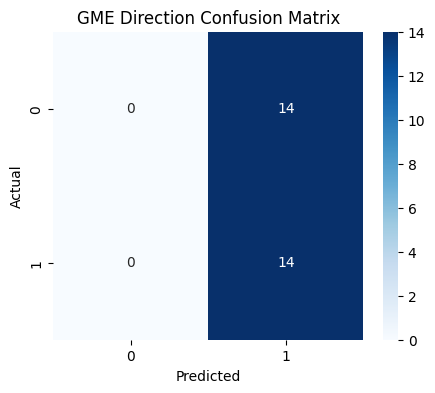

In [10]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Test Accuracy:", acc)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'{TICKER} Direction Confusion Matrix')
plt.show()

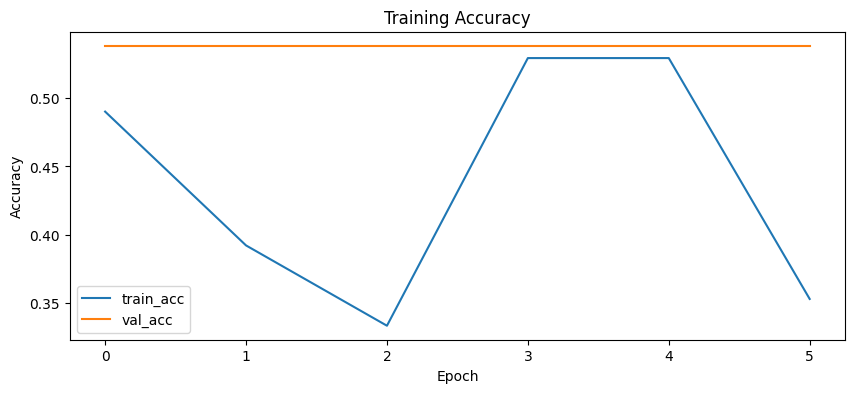

In [11]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()